<center>
    <b>
        <font size="+3">
            Food Pairing and Data Science
        </font>
    </b>
    <br>
    <br>
    Vincent Choo
</center>

# Introduction

[Food pairing](https://en.wikipedia.org/wiki/Foodpairing) is a principle for deciding which foods, when eaten together, are better flavor-wise. [One study, *Flavor network and the principles of food
pairing* published in *Nature*](https://www.nature.com/articles/srep00196), found that Western cooking, for example, prefers to pair foods when they share many flavors, as opposed to Eastern cooking, which tends to pair foods when they contrast flavor-wise. When combined with knowledge of what foods are central to each culture, it then becomes possible to derive insights what gives each cuisine its style.

Hypothetically, a [fusion restuarant](https://en.wikipedia.org/wiki/Fusion_cuisine) might choose to cook in a distinctly Eastern style (contrasting flavors) using mostly Western ingredients. It might even be possible to generate new cuisine styles that are designed to be as different as possible from existing styles. However, before any of that happens, we'll need data on food, and lots of it.

# Overview

First, we'll need a database of flavor compounds in each kind of food ingredient. Several databases concerning food exist, such as [FoodDB](http://foodb.ca/), [FlavorNet](http://www.flavornet.org/), and [FlavorDB](https://www.ncbi.nlm.nih.gov/pubmed/29059383), but not all associate foods with the compounds they contain. The one at FlavorDB does, so we can scrape our data from the FlavorDB [website](https://cosylab.iiitd.edu.in/flavordb/).

Once we have the data, we'll need it in a form that we can easily manipulate. [``Pandas DataFrames``](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html) are a good choice - they're effectively small databases that we can access and manipulate with the power of Python's other libraries, and without the need for a SQL-like syntax.

Then, we'll be able to run all sorts of nice data visualizations and analysis methods on our ``DataFrames``.

# Acquiring Data

First things first - how do we go about scraping the data from FlavorDB?

The general steps to data scraping are:
1. **Download** the JSON files which describe the chemical makeup of the food.
    - Find the URLs which have the JSON files.
    - Iterate over the URLs that have these JSON files, and download the data in them.
2. **Process** the JSON data by converting it into a Pandas ``Dataframe``.
3. **Clean** the ``DataFrame``.

## Steps 1-2: JSON Files

A quick inspection of the FlavorDB website reveals that all of the JSON files we want are at https://cosylab.iiitd.edu.in/flavordb/entities_json?id=x, where ``x`` is an integer. Then it's a cinch to write a few functions which go to those addresses and converts those JSON files into dictionaries. 

In [1]:
# import the relevant Python packages
!pip install mpld3
!pip install "git+https://github.com/javadba/mpld3@display_fix"
!pip install colour

# for basic data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# for downloading files off the internet
import urllib.request
import json
import time


# for network graphs
from colour import Color
from matplotlib.collections import LineCollection
import networkx as nx
import mpld3

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/javadba/mpld3 (to display_fix) to /tmp/pip-s3uo8vu6-build
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# JSON files are at addresses of this form
def flavordb_entity_url(x):
    return "https://cosylab.iiitd.edu.in/flavordb/entities_json?id="+str(x)


# translates the JSON file at the specified web address into a dictionary
def get_flavordb_entity(x):
    # source: https://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
    with urllib.request.urlopen(flavordb_entity_url(x)) as url:
        return json.loads(url.read().decode())
    return None

Those dictionaries contain a lot of unnecessary information, which is why we need to specify what fields we want (and, for ease of use, what we want to rename them to).

In [3]:
# the names of the "columns" in the raw JSON objects
def flavordb_entity_cols():
    return [
        'entity_id', 'entity_alias_readable', 'entity_alias_synonyms',
        'natural_source_name', 'category_readable', 'molecules'
    ]


# what we want to rename the JSON object "columns" to
def flavordb_df_cols():
    return [
        'entity id', 'alias', 'synonyms',
        'scientific name', 'category', 'molecules'
    ]


# "subcolumns" in the "molecules" column that we are interested in
def molecules_df_cols():
    return ['pubchem id', 'common name', 'flavor profile']    

## Steps 3-4: Downloading & Cleaning

We still haven't actually wrote anything that executes - just a bunch of definitions. Right now, we need to define a bunch of stuff as setup. Then, when we download the JSON data later, we can immediately pipeline it through processing and cleaning.

The end goal is to have the data in a consistent, easy to access format. That means that I want two databases, one associating foods with food compounds, and another associating food compounds with flavors. The database columns should have the following types:
* 'entity id' and 'pubchem id' to be type ``int``
* 'alias', 'scientific name', 'category', and 'common name' to be type ``str``
* 'synonyms' and 'flavor profile' should be type ``set(str)``
* 'molecules' should be a ``set(int)``

When these columns are initially downloaded, some of them, such as 'scientific name', have mixed types - they have both strings and some other value (in this case, ``NaN``). Fortunately, not too many columns have mixed types. In particular, (if you do some preliminary work and examine the JSON files,) the columns 'entity id', 'pubchem id', and 'common name' don't require type checking, so we don't have to process those at all.

The other small thing that do here is call ``str.lower()`` on all of the strings, just so it's easier to type and it can match other recipes more easily.

In [4]:
def clean_flavordb_dataframes(flavor_df, molecules_df):
    """
    Helps ensure consistent intra-column typing and converts all strings to lowercase.
    """
    strtype = type('')
    settype = type(set())
    
    # ensuring that these columns have type str
    for k in ['alias', 'scientific name', 'category']:
        flavor_df[k] = [
            elem.strip().lower() if isinstance(elem, strtype) else ''
            for elem in flavor_df[k]
        ]
    
    # ensuring that these columns are always a set of str
    def map_to_synonyms_set(elem):
        if isinstance(elem, settype):
            return elem
        elif isinstance(elem, strtype):
            # if it's a string of a set,
            if elem[0] == '{' and elem[-1] == '}':
                # convert it to a set
                return eval(elem)
            else:
                # else it's probably directly from source
                return set(elem.strip().lower().split(', '))
        else:
            return set()
    
    flavor_df['synonyms'] = [
        map_to_synonyms_set(elem)
        for elem in flavor_df['synonyms']
    ]
    
    molecules_df['flavor profile'] = [
        set([x.strip().lower() for x in elem])
        for elem in molecules_df['flavor profile']
    ]
    
    return [
        flavor_df.groupby('entity id').first().reset_index(),
        molecules_df.groupby('pubchem id').first().reset_index()
    ]

This is where most of the work is done. ``get_flavordb_dataframes()`` is the code that ties together all three steps of data scraping: **downloading**, **processing**, and **cleaning**. It even handles errors, for when a JSON page is missing.

In [5]:
# generate dataframes from some of the JSON objects
def get_flavordb_dataframes(start, end):
    """
    Download JSON data, converts it to DataFrames, and cleans them.
    
    Returns DataFrames for both foods and molecules, as well as missing JSON entries.
    """
    # make intermediate values to make dataframes from
    flavordb_data = []
    molecules_dict = {}
    missing = [] # numbers of the missing JSON files during iteration
    
    flavordb_cols = flavordb_entity_cols()
    
    for i in range(start, end):
        # we use a try-except here because some of the JSON pages are missing
        try:
            # 1: Find the JSON file. Gets the ith food entity, as a JSON dict
            fdbe = get_flavordb_entity(i + 1)

            # get only the relevant fields (columns) of the dict
            flavordb_series = [fdbe[k] for k in flavordb_cols[:-1]]
            flavordb_series.append( # convert the field to a set
                set([m['pubchem_id'] for m in fdbe['molecules']])
            )
            flavordb_data.append(flavordb_series)

            # update the molecules dataframe with the data in 'molecules' field
            for m in fdbe['molecules']:
                if m['pubchem_id'] not in molecules_dict:
                    molecules_dict[m['pubchem_id']] = [
                        m['common_name'],
                        set(m['flavor_profile'].split('@'))
                    ]
        except urllib.error.HTTPError as e:
            if e.code == 404: # if the JSON file is missing
                missing.append(i)
            else:
                raise RuntimeError(
                    'Error while fetching JSON object from ' + flavordb_entity_url(x)
                ) from e
            
    # generate the dataframes
    flavordb_df = pd.DataFrame(
        flavordb_data,
        columns=flavordb_df_cols()
    )
    molecules_df = pd.DataFrame(
        [
            [k, v[0], v[1]]
             for k, v in molecules_dict.items()
        ],
        columns=molecules_df_cols()
    )
    
    # clean up the dataframe columns
    flavordb_df, molecules_df = clean_flavordb_dataframes(flavordb_df, molecules_df)
    
    return [flavordb_df, molecules_df, missing]

It takes a long time to download all of these JSON files. If the code somehow crashes, we'll lose all of our download progress in a few short seconds. Therefore, it's a good idea to save the download progress.

In [6]:
# updates & saves the download progress of your dataframes
def update_flavordb_dataframes(df0, df1, ranges):
    """
    Adds more data to the specified DataFrames, and saves them as CSV files.
    
    If successful, returns the specified DataFrames, now updated, and any missing JSON files.
    """
    df0_old = df0
    df1_old = df1
    missing_old = []

    # time how long it took to download the files
    start = time.time()
    
    # for each range in ranges, save your progress.
    # don't continue with the program unless everything succeeds!
    try:
        for a, b in ranges:
            df0_new, df1_new, missing_new = get_flavordb_dataframes(a, b)
            
            df0_old = df0_old.append(df0_new, ignore_index=True)
            df1_old = df1_old.append(df1_new, ignore_index=True)
            missing_old.extend(missing_new)
        
        return df0_old, df1_old, missing_old
    except:
        raise # always throw the error so you know what happened
    finally:
        # even if you throw an error, you'll have saved them as csv files
        df0_old.to_csv('flavordb.csv')
        df1_old.to_csv('molecules.csv')

        end = time.time()
        mins = (end - start) / 60.0
        print('Downloading took: '+ str(mins) + ' minutes')

As of today, it looks like FlavorDB has about 1,000 distinct foods (entities). We'll get the first 1,000 foods we find, and save our progress about every 50 or so foods downloaded.

In [ ]:
# take new dataframes
df0 = pd.DataFrame(columns=flavordb_df_cols())
df1 = pd.DataFrame(columns=molecules_df_cols())

# fill the DataFrames with JSON files up to id = 1000
ranges = [(50 * i, 50 * (i + 1)) for i in range(20)]
# update & save the dataframes as csv files
update_flavordb_dataframes(df0, df1, ranges)

Creating a DataFrame from a CSV file is a lot faster than downloading and creating one from the internet. In a perfect world, we wouldn't need to, but in the interest of saving time, I've made these methods so that I don't need to redownload the ``DataFrames`` every time I make an edit to the code. They load the ``DataFrame``s from CSV files and recover the information about what JSON IDs are missing.

In [7]:
# get the missing entries
def missing_entity_ids(flavor_df):
    """
    Get the IDs of the missing JSON entries for this particular food DataFrame.
    """
    out = []
    entity_id_set = set(flavor_df['entity id'])
    for i in range(1, 1 + max(entity_id_set)):
        if i not in entity_id_set:
            out.append(i)
    return out


# loads the dataframes from csv files
def load_db():
    settype = type(set())
    
    df0 = pd.read_csv('flavordb.csv')[flavordb_df_cols()]
    df0['synonyms'] = [eval(x) if isinstance(x, settype) else x for x in df0['synonyms']]
    df0['molecules'] = [eval(x) for x in df0['molecules']]
    
    df1 = pd.read_csv('molecules.csv')[molecules_df_cols()]
    df1['flavor profile'] = [eval(x) for x in df1['flavor profile']]
    
    df0, df1 = clean_flavordb_dataframes(df0, df1)
    return df0, df1, missing_entity_ids(df0)

Okay, now we can finally display a few rows of our ``DataFrame``s.

In [8]:
# missing_ids = the missing ids that are less than the max one found
flavor_df, molecules_df, missing_ids = load_db()
flavor_df.to_csv('flavordb.csv')
molecules_df.to_csv('molecules.csv')
flavor_df.head()

,entity id,alias,synonyms,scientific name,category,molecules
0,1,bakery products,{bakery products},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}"
1,2,bread,{bread},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ..."
2,3,rye bread,{rye bread},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80..."
3,4,wheaten bread,"{soda scones, soda farls}",wheat,bakery,"{6915, 5365891, 12170, 8082, 31251, 7958, 1049..."
4,5,white bread,{white bread},wheat,bakery,"{7361, 994, 10883, 7362, 11173, 5365891, 11559..."


In [9]:
molecules_df.head()

,pubchem id,common name,flavor profile
0,4,1-Aminopropan-2-ol,{fishy}
1,49,3-Methyl-2-oxobutanoic acid,{fruity}
2,58,2-oxobutanoic acid,"{sweet, creamy, caramel, lactonic, brown}"
3,70,4-Methyl-2-oxovaleric acid,{fruity}
4,72,"3,4-Dihydroxybenzoic Acid","{mild, balsamic, phenolic}"


In [10]:
print('Missing IDs: ' + str(missing_ids))

Missing IDs: [406, 407, 420, 479, 483, 599, 605, 666, 681, 689, 692, 760, 761, 779, 797, 798, 801, 802, 804, 808, 809, 811, 812, 813, 816, 819, 838, 844, 866, 877, 888, 892, 903, 910, 922, 940, 946, 957, 966, 973, 974, 975, 976]


One last check: what are the values in category?

In [11]:
str(set(flavor_df['category']))

"{'spice', 'beverage caffeinated', 'seed', 'additive', 'fruit', 'vegetable', 'herb', 'vegetable root', 'vegetable tuber', 'vegetable fruit', 'legume', 'meat', 'vegetable stem', 'beverage', 'maize', 'berry', 'cabbage', 'beverage alcoholic', 'plant', 'fish', 'dish', 'essential oil', 'plant derivative', 'fungus', 'seafood', 'bakery', 'fruit citrus', 'cereal', 'gourd', 'dairy', 'nut', 'fruit-berry', 'flower', 'fruit essence'}"

Oops. It looks like we still have some more data cleaning to do. What's the difference between a vegetable, fruit, and vegetable fruit? How come cabbage gets its own category? Let's take a closer look. If we take a quick glance through the names of *every* food in FlavorDB (output not included), we'll notice a few strange things:

In [12]:
aliases_by_category = ''
for c in set(flavor_df['category']):
    aliases_by_category += (
        c + ': '
        + str(list(flavor_df[flavor_df['category'] == c]['alias']))
        + '\n\n'
    )
# check out the output of this yourself, if you like
# print(aliases_by_category)

It looks like some entries/categories were made erroneously (see elderberry, cornbread, japanese pumpkin). A few looked incorrect but were correct (corn salad, or cornsalad, is a type of leafy vegetable), but a lot were seemed like they were sorted to make sure no one category is too large. However, I can see signficant differences in flavor between categories.

We're mostly interested in the ingredients list, not in finished products like cornbread, so we'll keep only raw ingredients, remove a few outliers, and give them each a food group:

(Also: woah! [Apparently tobacco is a food.](https://www.scmp.com/magazines/post-magazine/article/1701428/how-cook-using-tobacco-sweet-and-savoury-dishes))

In [13]:
def food_groups():
    return set([
        'grain', 'vegetable', 'fruit', 'protein',
        'dairy', 'fat', 'sugar', 'seasoning',
        'beverage', 'alcohol'
    ])


# don't worry about the details in this! It's just a lot of sorting.
def get_food_group(food, category):
    """
    Maps each food category to a food group.
    
    The food groups include the main five: grain, vegetable, fruit, protein,
    dairy, fat, and sugar. However, they also include others: seasonings,
    beverages, alcohol.
    """
    
    out = None # return None if you don't know/want to classify it
    
    # broadly classify the major food groups
    if category in ['bakery', 'vegetable tuber', 'cereal']:
        out = 'grain'
    elif category in [
        'flower', 'fungus', 'plant', 'cabbage',
        'vegetable fruit', 'herb', 'gourd', 'vegetable'
    ]:
        out = 'vegetable'
    elif category in [
        'fruit-berry', 'berry', 'fruit', 'fruit citrus'
    ]:
        out = 'fruit'
    elif category in [
        'legume', 'nut', 'seed', 'seafood', 'fish', 'meat'
    ]:
        out = 'protein'
    elif category in ['dairy']:
        out = 'dairy'
    elif category in [
        'fruit essence', 'additive', 'spice', 'essential oil'
    ]:
        out = 'seasoning'
    elif category in ['beverage alcoholic']:
        out = 'alcohol'
    elif 'beverage' in category:
        out = 'beverage'
    elif category == 'maize':
        if food in ['corn', 'sweetcorn']:
            out = 'vegetable'
        elif food in ['cornbread', 'corn grits', 'popcorn']:
            out = 'grain'
        elif food == 'corn oil':
            out = 'fat'
    elif category == 'plant derivative':
        if (any(x in food for x in ['sauce', 'vinegar'])
            or food in ['creosote', 'storax', 'cocoa powder']):
            # creosote is what gives smoky foods that smoky flavor
            # storax is...weird
            out = 'seasoning'
        elif 'seed' in food or food == 'peanut butter':
            # cottonseeds are now available for people to eat!
            out = 'protein'
        elif any([x in food for x in ['butter', 'oil']]):
            out = 'fat'
        elif food == 'fermented tea':
            out = 'beverage'
        elif food in ['honey', 'chocolate', 'chocolate spread']:
            out = 'sugar'
        elif food == 'macaroni':
            out = 'grain'
        elif food in ['jute', 'tofu']:
            out = 'vegetable'
        elif food == 'soy yogurt':
            out = 'dairy'
    elif category == 'additive':
        if 'sugar' in food or food in [
            'fruit preserve', 'syrup', 'icing', 'molasses'
        ]:
            out = 'sugar'
        elif 'margarine' in food or food in ['cooking oil', 'shortening']:
            out = 'fat'
        elif food in ['sauce', 'gelatin dessert', 'spread', 'topping', 'water']:
            out = None # don't know how to classify these items
        elif food == 'stuffing':
            out = 'grain'
        else:
            out = 'seasoning'
    
    # cover exceptions to the rule
    if (
        any([
            food == x + ' oil'
            for x in ['soybean', 'cooking', 'fish', 'peanut', 'canola', 'corn']
        ])
        or food in ['butter', 'ghee']
        or (' butter' in food and food != 'peanut butter')
        or 'margarine' in food
    ):
        out = 'fat'
    elif food in [
        'sugar', 'honey', 'molasses', 'agave', 'dulce de leche'
    ]:
        # these were classified under 'additives/dairy/plant derivative'
        out = 'sugar'
    elif food in ['irish moss', 'kelp', 'kombu', 'wakame']:
        # these were classified under 'seafood'
        out = 'vegetable'
    elif food in ['butternut squash', 'winter squash', 'japanese pumpkin']:
        # these were classified under 'fruit'
        out = 'vegetable'
    elif food in ['sweet custard', 'candy bar', 'chocolate mousse', 'fudge']:
        out = 'sugar'

    return out


# make a DataFrame saving the results & food groups
ridf = flavor_df.copy() # ridf = raw ingredients df
ridf['group'] = [
    get_food_group(ridf.at[i, 'alias'], ridf.at[i, 'category'])
    for i in ridf.index
]
ridf = ridf[[
    g is not None
    for g in ridf['group']
]]
ridf = ridf.reset_index()
ridf.head()

,index,entity id,alias,synonyms,scientific name,category,molecules,group
0,0,1,bakery products,{bakery products},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}",grain
1,1,2,bread,{bread},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ...",grain
2,2,3,rye bread,{rye bread},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80...",grain
3,3,4,wheaten bread,"{soda scones, soda farls}",wheat,bakery,"{6915, 5365891, 12170, 8082, 31251, 7958, 1049...",grain
4,4,5,white bread,{white bread},wheat,bakery,"{7361, 994, 10883, 7362, 11173, 5365891, 11559...",grain


# Exploratory Data Analysis

## Preliminary Analysis

Done! Now we have a large database of foods. But how comprehensive is the data? Let's check by looking for some odd foods.

In [14]:
foods = ['caramel', 'urchin', 'liver',
         'blood', 'cheese', 'pawpaw', 'rose',
         'durian', 'squirrel', 'kombu', 'whale',
         'white fish', 'whitefish']

# check if any food matches (or is a substring of) an alias in the database
{f : any([f in alias for alias in ridf['alias']])
 for f in foods}

{'caramel': False,
 'urchin': False,
 'liver': False,
 'blood': False,
 'cheese': True,
 'pawpaw': True,
 'rose': True,
 'durian': True,
 'squirrel': True,
 'kombu': True,
 'whale': True,
 'white fish': False,
 'whitefish': True}

Hmmm. This database is not exactly complete. While the database certainly includes some uncommon foods like [whale](https://en.wikipedia.org/wiki/Whale_meat), [durian](https://en.wikipedia.org/wiki/Durian), [paw-paw](https://en.wikipedia.org/wiki/Asimina_triloba), and [rose](https://en.wikipedia.org/wiki/Rose#Food_and_drink), it is also missing others such as [sea urchin](https://en.wikipedia.org/wiki/Sea_urchin#As_food), [liver](https://en.wikipedia.org/wiki/Liver_(food)), and [blood](https://en.wikipedia.org/wiki/Blood_as_food) (see [black pudding](https://en.wikipedia.org/wiki/Black_pudding)). In addition, common terms, like ["white fish"](https://en.wikipedia.org/wiki/Whitefish_(fisheries_term)), which refers to several species of fish, are left out entirely ("whitefish" refers to a single species of fish).

Of course, we wouldn't expect this database to have the food compounds of caramel, because even today, the [process of caramelization](https://www.scienceofcooking.com/caramelization.htm) is [extremely complex](https://www.exploratorium.edu/cooking/candy/caramels-story.html) and [not well-understood](https://bcachemistry.wordpress.com/2014/05/11/the-chemistry-of-caramel/), so [complete information on caramel](https://chem-net.blogspot.com/2015/04/food-chemistry-caramelization-sugar15.html) shouldn't be there.

Now that's out of the way, it's time for analysis and visualizations!

## Similar Foods

Which foods are most similar to each other? From the previously mentioned [Nature article](https://www.nature.com/articles/srep00196), the mean number of shared compounds per recipe is given by ``msc()``:

In [15]:
def get_food(food_name, fdf):
    return fdf[[
        (fdf.at[i, 'alias'] == food_name
         or food_name in fdf.at[i, 'synonyms'])
        for i in fdf.index
    ]]


def get_molecules(food_name, fdf):
    out = list(get_food(food_name, fdf)['molecules'])
    if len(out) > 1:
        raise ValueError('food ' + food_name + ' has more than one entry')
    return out[0]
    
    
def msc(foods, fdf, **kwargs):
    """
    Return the mean shared compounds (MSC) for a given recipe (set of foods),
    i.e. sum(# shared compounds per 2 foods) / (# of combinations of 2 foods)
    """
    use_index = kwargs.get('use_index', False)
    if use_index:
        mols = [fdf.at[i, 'molecules'] for i in foods]
    else:
        mols = [get_molecules(f, fdf) for f in foods]
    
    nr = len(foods)
    out = 0
    for i in range(nr):
        for j in range(i + 1, nr):
            out += len(mols[i].intersection(mols[j]))
    out *= 2.0 / (nr * (nr - 1))
    return out

Since we only have ~1,000 foods in our ``DataFrame``, it's not too expensive to find the MSC between every two foods. Then, we can look for "clusters" of similar foods and ones that very different from one another.

In [16]:
def block_msc(foods0, foods1, fdf, **kwargs):
    """
    Get the MSC when comparing each of the foods in foods0 to each of the foods in foods1.
    """
    len0 = len(foods0)
    len1 = len(foods1)
    
    out = np.ndarray((len0, len1))
    for i in range(len0):
        for j in range(len1):
            out[i][j] = msc([foods0[i], foods1[j]], fdf, **kwargs)
    
    return out


def intragroup_msc(foods, fdf, **kwargs):
    lenf = len(foods)
    food_msc = block_msc(foods, foods, fdf, **kwargs)
    
    out = []
    for i in range(lenf):
        out.append([])
        for j in range(1 + i, lenf):
            out[-1].append(food_msc[i][j])
    
    return out


def flatten(ls):
    return [x for sublist in ls for x in sublist]

In [17]:
msc_data = flatten(intragroup_msc(ridf.index, ridf, use_index=True))

Now that we have the MSC between all pairs of food, let's see how many compounds foods normally share:

Average: 21.7043497344
Median: 3.0


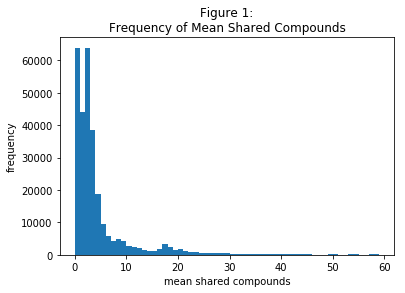

In [18]:
print('Average: ' + str(np.average(msc_data)))
print('Median: ' + str(np.median(msc_data)))

fignum = 1
plt.hist(msc_data, bins=list(range(60)))
plt.title('Figure ' + str(fignum) + ':\nFrequency of Mean Shared Compounds')
plt.xlabel('mean shared compounds')
plt.ylabel('frequency')
plt.show()
fignum += 1

This shouldn't be that surprising; only similar foods (like beef and pork) should have similar compounds in them. The vast majority of foods taste really different from one another!

But wait, how similar are foods inside and outside their own food groups? To visualize that, use a violin plot:

In [19]:
def make_violin_plot(x, y, **kwargs):
    xl = kwargs.get('x_label', '')
    yl = kwargs.get('y_label', '')
    t = kwargs.get('title', '')
    w = kwargs.get('widths', 4)
    fs = kwargs.get('figsize', (10, 7.5))
    
    # create a sufficiently wide violin plot, with a median
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fs)
    ax.violinplot(y, x, widths=w, showmedians=True)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(t)

Huh. Looks like there are small groups of fats, vegetables, proteins, and dairy products that taste similar within themselves. Interesting.

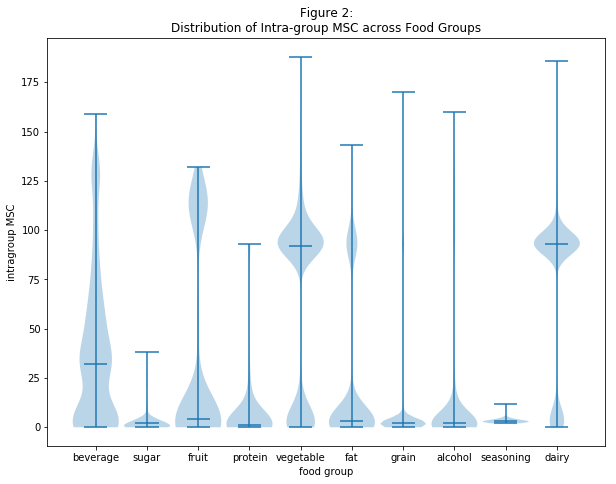

In [20]:
food_grouped = ridf.groupby(by='group')

x = list(food_groups())
xtic = list(range(len(x)))
y = [
    flatten(intragroup_msc(list(group.index), ridf, use_index=True))
    for fg, group in food_grouped
]
make_violin_plot(
    xtic,
    y,
    widths=0.9,
    x_label='food group',
    y_label='intragroup MSC'
)
plt.xticks(xtic, x)
plt.title('Figure ' + str(fignum) + ':\nDistribution of Intra-group MSC across Food Groups')
plt.show()
fignum += 1

We should also double check if our results (the number of shared compounds) match the [existing literature has reported](https://www.nature.com/articles/srep00196):

In [21]:
# from Figure 3 of the Nature article,
expected_num_compounds = [
    {'lemon': 69, 'shrimp': 63, 'shared': 9},
    {'coffee': 132, 'beef': 97, 'shared': 102}
]

print('Expected # of compounds:')
for x in expected_num_compounds:
    print(x)
print('')

print('Actual # of compounds:')
actual_num_compounds = []
for f0, f1, s in expected_num_compounds:
    # food 1, food 2, shared
    # get the molecules in each food
    mols = [get_molecules(x, ridf) for x in [f0, f1]]
    mols.append(mols[0].intersection(mols[1]))
    mols = [len(x) for x in mols]
    print({k: v for k, v in zip([f0, f1, s], mols)})

Expected # of compounds:
{'lemon': 69, 'shrimp': 63, 'shared': 9}
{'coffee': 132, 'beef': 97, 'shared': 102}

Actual # of compounds:
{'lemon': 193, 'shrimp': 76, 'shared': 17}
{'coffee': 269, 'beef': 92, 'shared': 37}


Looks like our database (FlavorDB) is somewhat different from the one that they used (which was derived from *Fenaroli's Handbook of Flavor Ingredients*). However, we might still be able to get useful information out of an analysis.

In [22]:
msc_matrix = block_msc(ridf.index, ridf.index, ridf, use_index=True)
ridf['msc sum'] = [
    sum(msc_matrix[i]) - msc_matrix[i][i]
    for i in ridf.index
]
ridf.head()

,index,entity id,alias,synonyms,scientific name,category,molecules,group,msc sum
0,0,1,bakery products,{bakery products},poacceae,bakery,"{27457, 7976, 31252, 26808, 22201, 26331}",grain,261.0
1,1,2,bread,{bread},poacceae,bakery,"{1031, 1032, 644104, 527, 8723, 31260, 15394, ...",grain,39386.0
2,2,3,rye bread,{rye bread},rye,bakery,"{644104, 7824, 643731, 8468, 1049, 5372954, 80...",grain,5497.0
3,3,4,wheaten bread,"{soda scones, soda farls}",wheat,bakery,"{6915, 5365891, 12170, 8082, 31251, 7958, 1049...",grain,1017.0
4,4,5,white bread,{white bread},wheat,bakery,"{7361, 994, 10883, 7362, 11173, 5365891, 11559...",grain,748.0


In [95]:
def make_network(edge_df, source, dest, **kwargs):
    """
    Make a network graph with labels.
    """
    nodelist = kwargs.get('nodelist', None)
    node_sizes = kwargs.get('node_sizes', None)
    node_colors = kwargs.get('node_colors', None)
    node_tooltips = kwargs.get('node_tooltips', None)
    lw = kwargs.get('linewidths', len(nodelist) * [0.25])
    fs = kwargs.get('figsize', (12,  8))
    t = kwargs.get('title', '')
    
    # associate each list with a key
    node_arrs = {
        'size': node_sizes,
        'color': node_colors,
        'tooltip': node_tooltips
    }
    
    # associate each node with some data
    node_data = {
        nodelist[i]: {
            k: arr[i]
            for k, arr in node_arrs.items()
            if arr is not None
        }
        for i in range(len(nodelist))
    }
    
    # create graph from edge list
    G = nx.from_pandas_edgelist(edge_df, source, dest)
    # generate positions of nodes in graph
    pos = nx.spring_layout(G)
    nodes, x, y = zip(*[[k, v[0], v[1]] for k, v in pos.items()])
    
    # now that we have a different order of nodes, change the order
    node_arrs = {
        k: None if arr is None else [node_data[n][k] for n in nodes]
        for k, arr in node_arrs.items()
    }
    
    # prepare the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fs)
    # add the nodes
    scatter = ax.scatter(x, y, s=node_arrs['size'], c=node_arrs['color'])
    
    # add the edges
    line_segments = LineCollection(
        [
            [pos[src], pos[dst]]
            for src, dst in zip(edge_df[source], edge_df[dest])
        ],
        colors='black',
        linewidths=lw
    )
    ax.add_collection(line_segments)
    
    # add tooltips, if any
    if node_arrs['tooltip'] is not None:
        tooltip = mpld3.plugins.PointLabelTooltip(
            scatter,
            labels=node_arrs['tooltip']
        )
        mpld3.plugins.connect(fig, tooltip)
    else:
        mpld3.plugins.connect(fig)
    
    # some extra style to help with the graph
    ax.grid(color='white', linestyle='solid')
    plt.title(t)
    # make sure to follow up with mpld3.display() )

In [96]:
def trubetskoy_colors():
    """
    Return 20 distinct colors as detailed by Sasha Trubetskoy.
    
    https://sashat.me/tag/color/
    """
    return [
        "#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
        "#911eb4", "#9A6324", "#42d4f4", "#f032e6", "#bfef45",
        "#fabebe", "#469990", "#e6beff", "#fffac8", "#800000",
        "#aaffc3", "#808000", "#ffd8b1", "#000075", "#a9a9a9"
    ]
    

def get_color_gradient(color0, color1, steps):
    """
    Get hex color values in a gradient, from color0 to color1.
    """
    return [c.rgb for c in list(color0.range_to(color1, steps))]

In [97]:
ridf100 = ridf.sort_values(by='msc sum', axis=0, ascending=False).head(100)
ridf100

,index,entity id,alias,synonyms,scientific name,category,molecules,group,msc sum
308,309,310,tea,{tea},camellia sinensis,plant,"{12297, 5281804, 77837, 522266, 4133, 6184, 53...",vegetable,47728.0
161,161,162,apple,{apple},malus,fruit,"{8193, 8194, 229377, 12293, 12294, 1031, 64410...",fruit,45932.0
182,182,183,guava,{guava},psidium guajava,fruit,"{31234, 644104, 429065, 4564493, 12813, 535246...",fruit,45031.0
359,363,364,tomato,{tomato},solanum,vegetable fruit,"{5283335, 644104, 1032, 1031, 5283339, 527, 53...",vegetable,44776.0
181,181,182,grape,{grape},vitis,fruit,"{5283329, 61953, 62465, 5364231, 644104, 42906...",fruit,44663.0
189,189,190,mango,{mango},mangifera,fruit,"{8193, 8194, 5283335, 644104, 429065, 12810, 1...",fruit,44377.0
281,282,283,cocoa,{cocoa},theobroma,seed,"{5283329, 1030, 30215, 644104, 429065, 1031, 1...",protein,44141.0
363,372,373,potato,{potato},solanum,vegetable tuber,"{8193, 30215, 644104, 31246, 527, 5364752, 528...",grain,43733.0
195,195,196,papaya,"{pawpaw, papaw}",carica,fruit,"{12294, 1031, 644104, 429065, 1032, 31246, 527...",fruit,43684.0
233,233,234,strawberry,{strawberry},fragaria,berry,"{31234, 1031, 644104, 429065, 12810, 229387, 5...",fruit,43640.0


In [98]:
def food_color_map():
    return {
        'grain': "#ffe119", # yellow
        'vegetable': "#3cb44b", # green
        'fruit': "#f032e6", # purple
        'protein': "#e6194B", # red
        'seasoning': "#f58231", # orange
        'dairy': "#a9a9a9", # grey
        'fat': "#9A6324", # brown
        'sugar': "#800000", # maroon
        'beverage': "#4363d8", # blue
        'alcohol': "#42d4f4" # turquoise
    }

In [99]:
ridf100_edges = flatten([
    [
        [ridf100.index[i], ridf100.index[j]]
        for j in range(1 + i, len(ridf100.index))
        if msc_matrix[ridf100.index[i]][ridf100.index[j]] > 0
    ]
    for i in range(len(ridf100.index))
])

edge_ridf100 = pd.DataFrame(ridf100_edges, columns=['a', 'b'])
edge_ridf100['weight'] = [
    msc_matrix[a][b]
    for a, b in zip(edge_ridf100['a'], edge_ridf100['b'])
]
edge_ridf100 = edge_ridf100.sort_values(by='weight', axis=0, ascending=False).head(100)

max_edge_weight = max(edge_ridf100['weight'])
edge_ridf100['weight'] = [
    w / max_edge_weight
    for w in edge_ridf100['weight']
]

# map each food group to a color gradient
fcmap = {
    k: get_color_gradient(Color('white'), Color(v), int(max_sum))
    for k, v in food_color_map().items()
}

In [119]:
max_sum = max(ridf100['msc sum'])
sizes = [
    1000.0 * (msc_sum / max_sum)**10
    for msc_sum in ridf100['msc sum']
]

ncolors = [
    fcmap[g][int((mscs**2) / (max_sum**1)) - 1]
    for g, mscs in zip(ridf100['group'], ridf100['msc sum'])
]

widths = [
    2 * w**10
    for w in edge_ridf100['weight']
]

In [121]:
make_network(
    edge_ridf100, 'a', 'b',
    nodelist=list(ridf100.index),
    node_sizes=sizes,
    node_colors=ncolors,
    node_tooltips=list(ridf100['alias']),
    linewidths=widths,
    title='Figure ' + str(fignum) + ':\nNetwork Graph of Food Groups'
)
fignum += 1
mpld3.display()

# Note: the axes here are meaningless.
# see https://github.com/mpld3/mpld3/issues/197

(0.0, 1.0, 0.0, 1.0)

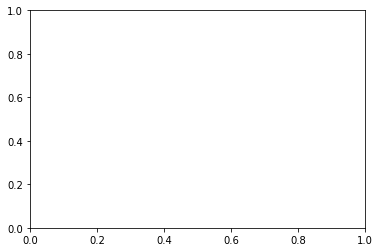

In [55]:
# use colour & networkx to make a graph with varying sizes of nodes & colors to map flavors
# import csv file of recipes
# algorithm to predict flavors of cuisines - generate new recipes, fusion cuisine
# bonus - predict ratings on recipes